# UDLF Non-Local Means (CPRR)
Images and data collected from experiments of UDLF Non-Local Means with CPRR as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

# Enable relative imports (snippet of code based on https://stackoverflow.com/a/61079434)
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
    
from nlmeans.nlmeans import nlmeans
from nlmeans.nlmeans_udlf import nlmeans_udlf

from parameters import *
from utils import *

## Parameters

In [2]:
# UDLF Parameters
udl_method = 'CPRR'
udl_params = get_udl_params(udl_method)
print(udl_method, udl_params)

CPRR {'k': 3, 't': 1}


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

<Figure size 640x480 with 0 Axes>

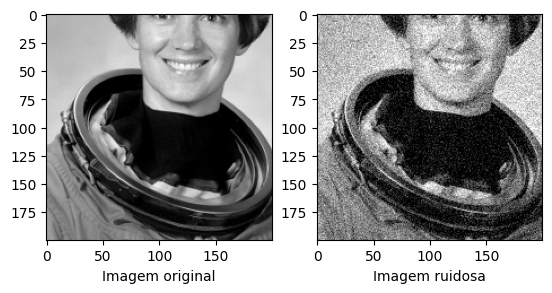

In [3]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

plt.set_cmap('gray')
plt.figure()

plt.subplot(1, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(1, 2, 2)
plt.xlabel('Imagem ruidosa')
plt.imshow(im_nse)
plt.show()

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 725 ms, sys: 4.83 ms, total: 730 ms
Wall time: 729 ms


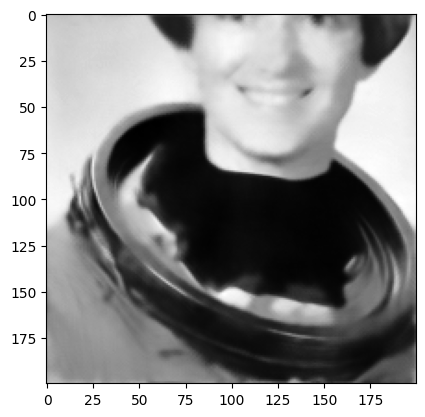

In [4]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1)

## UDLF Non-Local Means (NONE)
The results of the reranking method will be compared with Non-Local Means using the original ranked lists, that is, the ranked lists used as input to UDLF. 

CPU times: user 5.92 s, sys: 360 ms, total: 6.28 s
Wall time: 6.28 s


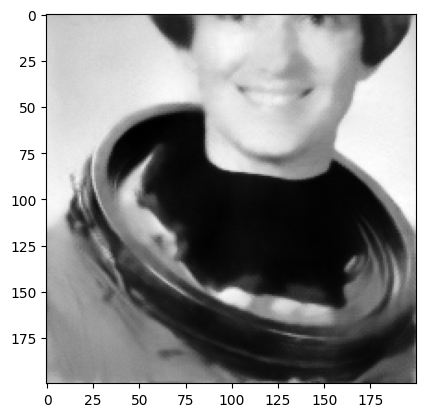

In [5]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()
plt.imshow(im_fil3, cmap='gray')

## UDLF Non-Local Means (CPRR)
This denoise the image using CPRR as the reranking method.

CPU times: user 6.3 s, sys: 405 ms, total: 6.7 s
Wall time: 13.1 s


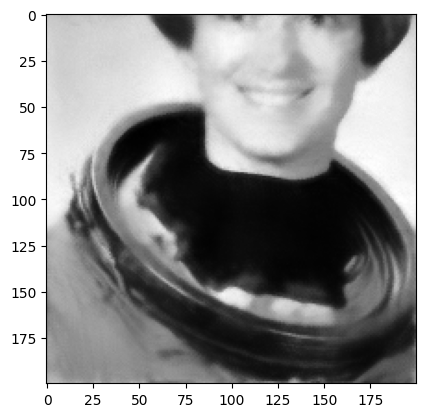

In [6]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()
plt.imshow(im_fil2)

### Show the images side by side

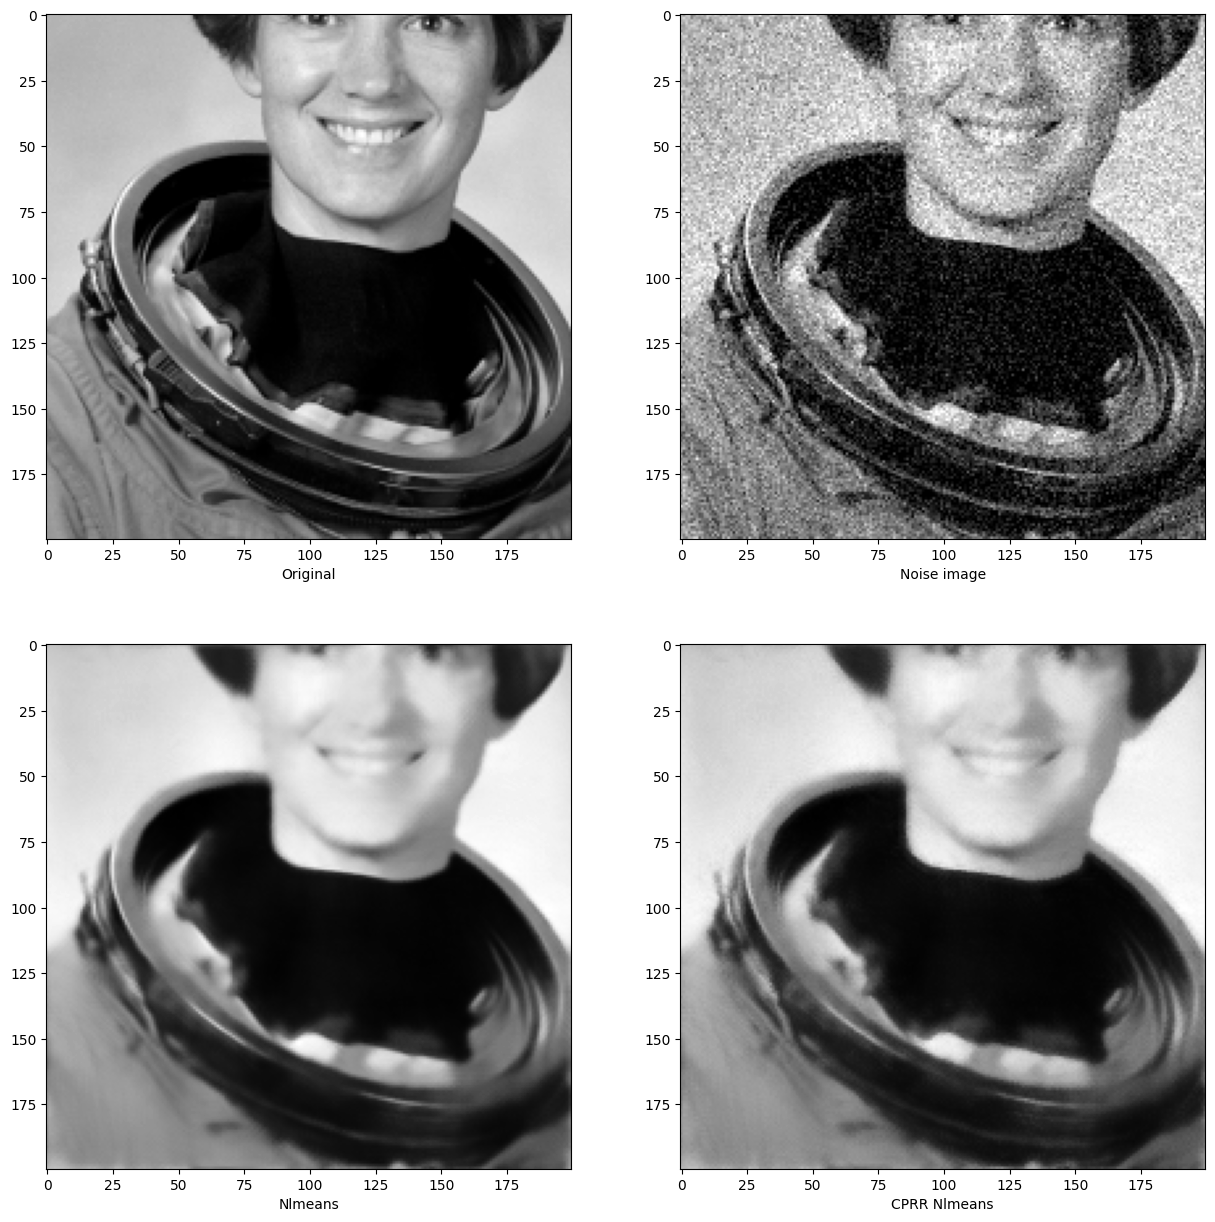

,Noise,Nlmeans,CPRR Nlmeans,NONE Nlmeans
PSNR,20.582626,23.142633,22.879415,23.327438
SSIM,0.450165,0.679699,0.673141,0.687343
MSE,0.008745,0.003362,0.003598,0.003233


In [7]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

In [8]:
def tune_params(im, im_nse, params_info, udl_params):
    # UDLF Method specific parameters
    k_params = params_info['k']
    k_values = range(k_params['start'], k_params['end'], k_params['step'])

    t_params = params_info['t']
    t_values = range(t_params['start'], t_params['end'], t_params['step'])

    # General variables
    psnr_max = 0
    best_im = None
    best_params = {'k': k_params['start'], 't': t_params['start']}
    psnr_values = np.zeros((len(k_values), len(t_values)))

    # Main loop
    for i, k in enumerate(k_values):
        for j, t in enumerate(t_values):
            udl_params['k'] = k
            udl_params['t'] = t

            im_fil = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
            rm_tmp_files()
            psnr_value = image_metrics(im, im_fil)[0]
            psnr_values[i][j] = psnr_value
            if psnr_value > psnr_max:
                psnr_max = psnr_value
                best_im = im_fil3
                best_params['k'] = k
                best_params['t'] = t

    return best_im, best_params, psnr_max, psnr_values

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [9]:
%%time
import sys

eval_info = []
eval_psnr = []
images_tested = []
print('Method:', udl_method)

params_info = {
    'k': {'start': 3, 'end': 22, 'step': 1},
    't': {'start': 1, 'end': 6,  'step': 1}
}

for image in images:
    im, im_name = get_image(image)
    im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

    # In case of error, the functions above return None
    if im is None:
        continue
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans (trying all parameters combinations possible)
    im_fil2, params, psnr_max, _ = tune_params(im, im_nse, params_info, udl_params)
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im, im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 

    # Evaluation
    im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
    im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
    im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
    im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape, im.dtype, params, psnr_max)

Method: CPRR
Tested with image: astronaut (200, 200) float64 {'k': 3, 't': 3}
Tested with image: brick (200, 200) float64 {'k': 21, 't': 1}
Tested with image: camera (200, 200) float64 {'k': 3, 't': 4}
Tested with image: cat (200, 200) float64 {'k': 3, 't': 1}
Tested with image: checkerboard (200, 200) float64 {'k': 21, 't': 1}
Tested with image: clock (200, 200) float64 {'k': 3, 't': 1}
Tested with image: coffee (200, 200) float64 {'k': 3, 't': 1}
Tested with image: coins (200, 200) float64 {'k': 16, 't': 1}
Tested with image: grass (200, 200) float64 {'k': 17, 't': 1}
Tested with image: gravel (200, 200) float64 {'k': 21, 't': 1}
Tested with image: horse (200, 200) float64 {'k': 21, 't': 3}
CPU times: user 1h 57min 28s, sys: 7min 50s, total: 2h 5min 19s
Wall time: 4h 39min 16s


### Show the results

In [13]:
results_df = pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method)
print('Number of images tested:', len(results_df))
results_df.style.apply(highlight_best_values, axis=1)
#pd.DataFrame(
#    data    = eval_info,
#    index   = images,
#    columns = ['PSNR Noise', 'SSIM Noise', 'MSE Noise', 
#               'PSNR Nlmeans', 'SSIM Nlmeans', 'MSE Nlmeans',
#               'PSNR RL-RECOM Nlmeans', 'SSIM RL-RECOM Nlmeans', 'MSE RL-RECOM Nlmeans',
#               'PSNR NONE Nlmeans', 'SSIM NONE Nlmeans', 'MSE NONE Nlmeans']
#)

CPRR
Number of images tested: 11


,Noise,Nlmeans,CPRR,NONE
astronaut,20.582626,23.142633,23.327438,23.327438
brick,20.079441,27.102462,7.383813,26.746031
camera,20.785065,27.146886,6.979061,27.095254
cat,20.010958,22.303322,7.897622,22.572579
checkerboard,22.430388,27.563894,2.192628,25.603540
clock,20.102114,31.022279,5.397533,30.980421
coffee,20.959080,26.621309,7.120025,26.576903
coins,20.291328,22.747732,8.315231,22.263549
grass,19.994935,15.810268,7.866583,16.006936
gravel,20.003076,18.606878,9.637319,18.774436


In [12]:
results_df[results_df['CPRR'] > results_df['Nlmeans']]

,Noise,Nlmeans,CPRR,NONE
astronaut,20.582626,23.142633,23.327438,23.327438
